# 1. Introduction

=======================================================================================================================================================================================================

Nama: Ardiansyah Putra Mahadika

Batch: BSD 006 

This program is developed in order to conduct analysis credit card data and forecast the credit card user be able to repay the bill in charges. The raw data is retrieved from BigQuery public data by conducting query sql to retrieve the raw data. 

=======================================================================================================================================================================================================

## Background

The usage of credit cards is common these days. Good financial management can make credit cards beneficial to have; however, it can also lead to defaults and other financial problems if not managed well. As the credit card issuer, it is crucial to predict whether a customer will be able to pay their credit card bill next month. By accurately predicting this, the bank can take appropriate actions regarding the credit and provide early notifications to the customer.

## Problem Statement

As the issuer of credit cards, it is crucial to predict whether a customer will default on their payment next month. Within the next 5 days, as a Data Scientist I be aiming to develop and deploy a predictive model using historical customer data to forecast whether a customer will default on their credit card payment next month. The model will target an accuracy of (in f-1 score) at least 50%, leveraging machine learning model. This initiative will enable the bank to take proactive measures in managing credit risk and provide early warnings to customers, thus improving financial stability.

## Bussiness Understanding

### Why F-1 Score?

The F1 score is the combination of calculation mean (average) of precision and recall, ensuring that the model does not focus solely on one metric but considers both in balance. 

In the context of credit, both false positives (predicting a default when there isn't one) and false negatives (failing to predict a default when there is one) have serious implications. False negatives can be particularly damaging as the bank may not take preventive action against genuinely risky customers, while false positives can inconvenience reliable customers and reduce customers trust in the bank. The F1 score ensures the model maintains a good balance between identifying genuinely at-risk customers (recall) and avoiding incorrectly flagging reliable customers as risky (precision). 

Using the F1 score provides a more comprehensive understanding of the model's overall performance compared to using accuracy score alone. Accuracy might be high simply by predicting the majority class but fails to give an accurate picture of the model's capability in handling the critical minority cases in default prediction.

### Columns Explanation

1. limit_balance: The amount of given credit in NT dollars, which includes individual and family/supplementary credit.

2. sex: Gender of the customer 
    
    1 = male
    
    2 = female

3. education_level: Education level of the customer 
    
    1 = graduate school, 
    
    2 = university, 
    
    3 = high school, 
    
    4 = others, 
    
    5 = unknown, 
    
    6 = unknown.

4. marital_status: Marital status of the customer 

    1 = married, 

    2 = single, 
    
    3 = others
    

5. age: Age of the customer in years.

6. pay_0: Repayment status in September 2005, with the following scale:


    -2 = no payment

    -1 = pay duly

    0 = no late payment

    1 = payment delay for one month

    2 = payment delay for two months

    ...

    8 = payment delay for eight months
    
    9 = payment delay for nine months and above


7. pay_2: Repayment status in August 2005 (scale same as above).

8. pay_3: Repayment status in July 2005 (scale same as above).

9. pay_4: Repayment status in June 2005 (scale same as above).

10. pay_5: Repayment status in May 2005 (scale same as above).

11. pay_6: Repayment status in April 2005 (scale same as above).

12. bill_amt_1: Amount of bill statement in September 2005 (NT dollars).

13. bill_amt_2: Amount of bill statement in August 2005 (NT dollars).

14. bill_amt_3: Amount of bill statement in July 2005 (NT dollars).

15. bill_amt_4: Amount of bill statement in June 2005 (NT dollars).

16. bill_amt_5: Amount of bill statement in May 2005 (NT dollars).

17. bill_amt_6: Amount of bill statement in April 2005 (NT dollars).

18. pay_amt_1: Amount of previous payment in September 2005 (NT dollars).

19. pay_amt_2: Amount of previous payment in August 2005 (NT dollars).

20. pay_amt_3: Amount of previous payment in July 2005 (NT dollars).

21. pay_amt_4: Amount of previous payment in June 2005 (NT dollars).

22. pay_amt_5: Amount of previous payment in May 2005 (NT dollars).

23. pay_amt_6: Amount of previous payment in April 2005 (NT dollars).

24. default_payment_next_month: Indicator of default payment next month 
    
    1 = yes 
    
    0 = no

# 2. Query SQL

```sql
SELECT  limit_balance, 
        CAST(sex AS INT64) AS sex, 
        CAST(education_level AS INT64) AS education_level, 
        CAST(marital_status AS INT64) AS marital_status, 
        age, 
        pay_0, 
        pay_2, 
        pay_3, 
        pay_4, 
        CAST(pay_5 AS FLOAT64) AS pay_5, 
        CAST(pay_6 AS FLOAT64) AS pay_6, 
        bill_amt_1, 
        bill_amt_2, 
        bill_amt_3, 
        bill_amt_4, 
        bill_amt_5, 
        bill_amt_6, 
        pay_amt_1, 
        pay_amt_2, 
        pay_amt_3, 
        pay_amt_4, 
        pay_amt_5, 
        pay_amt_6, 
        CAST(default_payment_next_month AS INT64) AS default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default` 
LIMIT 11982;

```

# 3. Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Feature Engineering
from sklearn.model_selection import train_test_split, GridSearchCV
from feature_engine.outliers import Winsorizer
from phik import phik_matrix
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

# Import Model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score


# Save Model 
import pickle

/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 4. Data Loading

- retrieve data set .csv file

In [2]:
# read csv file with pandas 
df_ori = pd.read_csv('P1G5_Set_1_ardiansyah_putra.csv')

# show dimension of the dataset
df_ori.shape

(2965, 24)

- exploring the informations and characteristic of data

In [3]:
# display first 10 data in dataset
df_ori.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [4]:
# check datatype on each feature (column) in dataset
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

In [5]:
# check the last 10 data in dataset
df_ori.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


In [6]:
# checking statistics information of dataset
df_ori.describe()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
count,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,...,2965.000000,2965.000000,2965.000000,2965.000000,2.965000e+03,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000
mean,163369.308600,1.607757,1.849578,1.559865,35.193255,0.005059,-0.122428,-0.141653,-0.185160,-0.225295,...,44089.683305,40956.080607,39773.072513,6348.902867,6.272494e+03,5150.497133,4561.376054,4913.286678,5382.701518,0.214165
std,125030.415472,0.488333,0.778184,0.522317,9.109439,1.114395,1.180784,1.183630,1.178322,1.159003,...,61907.454056,58271.904751,57303.488981,20885.735336,2.887967e+04,14287.079982,13281.499599,16734.340778,17275.953029,0.410311
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2582.000000,1958.000000,1430.000000,1013.000000,9.900000e+02,477.000000,313.000000,323.000000,173.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19894.000000,18814.000000,18508.000000,2234.000000,2.175000e+03,1994.000000,1600.000000,1646.000000,1615.000000,0.000000
75%,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58622.000000,53373.000000,52287.000000,5087.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4081.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,69.000000,8.000000,7.000000,7.000000,8.000000,7.000000,...,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000,1.000000


 - duplicate dataset into df ready to conduct analysis

In [7]:
# assigning copy of dataset into new variable
df = df_ori.copy(deep=True)

# 5. Exploratory Data Analysis 

In [8]:
df.columns

Index(['limit_balance', 'sex', 'education_level', 'marital_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6', 'default_payment_next_month'],
      dtype='object')

## a. Characteristic of bill amount of credit card user (customers)

In [9]:
# checking latest bill amount statistical informations
df['bill_amt_1'].describe()

count      2965.000000
mean      52118.305228
std       72328.670541
min      -11545.000000
25%        3958.000000
50%       24257.000000
75%       69852.000000
max      613860.000000
Name: bill_amt_1, dtype: float64

- The average latest bill of customers who have overdue (in month) status on credit card payments.

    -2 = no payment

    -1 = pay duly

    0 = no late payment

    1 = payment delay for one month

    2 = payment delay for two months

    ...

    8 = payment delay for eight months
    
    9 = payment delay for nine months and above


In [10]:
# Creating new table that provides the average bill amount for customers grouped by their default payment status for the next month.
df_group_1 = df.loc[(df['pay_0'] > 0)].groupby('default_payment_next_month')['bill_amt_1'].mean().reset_index()
df_group_1

,default_payment_next_month,bill_amt_1
0,0,32763.481481
1,1,56875.491124


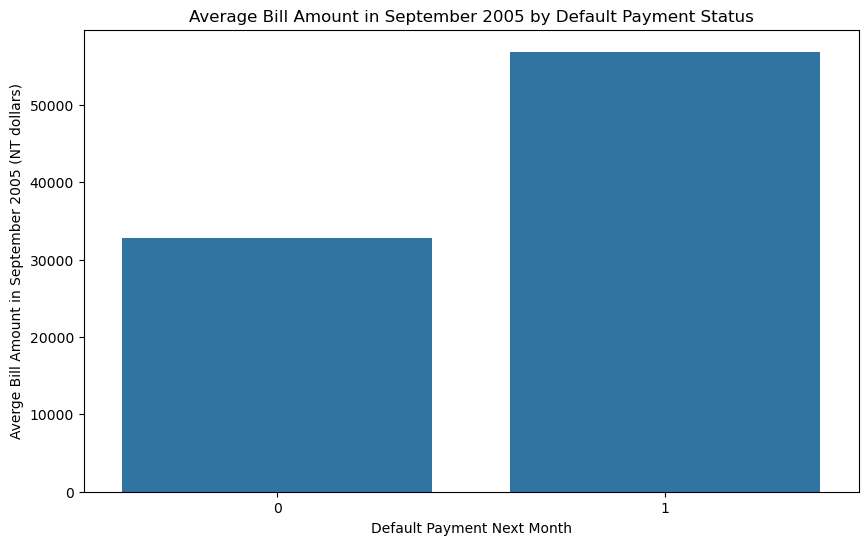

In [11]:
# Visualizing in bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='default_payment_next_month', y='bill_amt_1', data=df_group_1)
plt.xlabel('Default Payment Next Month')
plt.ylabel('Averge Bill Amount in September 2005 (NT dollars)')
plt.title('Average Bill Amount in September 2005 by Default Payment Status')
plt.show()

Insight: 
 - the average credit card bill for customers who still have outstanding payments and are marked as default in their repayment next month is about 56,875
 - high average bill amount for customer who as default status on next month repayment suggests that these customers represent a substantial risk to the bank in terms of potential losses

## b. Characteristic of limit balance the customer (credit card user)

In [12]:
# checking statistics informations of limit_balance column
df['limit_balance'].describe()

count      2965.000000
mean     163369.308600
std      125030.415472
min       10000.000000
25%       50000.000000
50%      140000.000000
75%      230000.000000
max      800000.000000
Name: limit_balance, dtype: float64

- How many customers have a credit limit above the overall average limit balance

In [13]:
# Calculating average of limit balance and assigning into new variable
avg_limit_balance = df['limit_balance'].mean()
avg_limit_balance

163369.30860033727

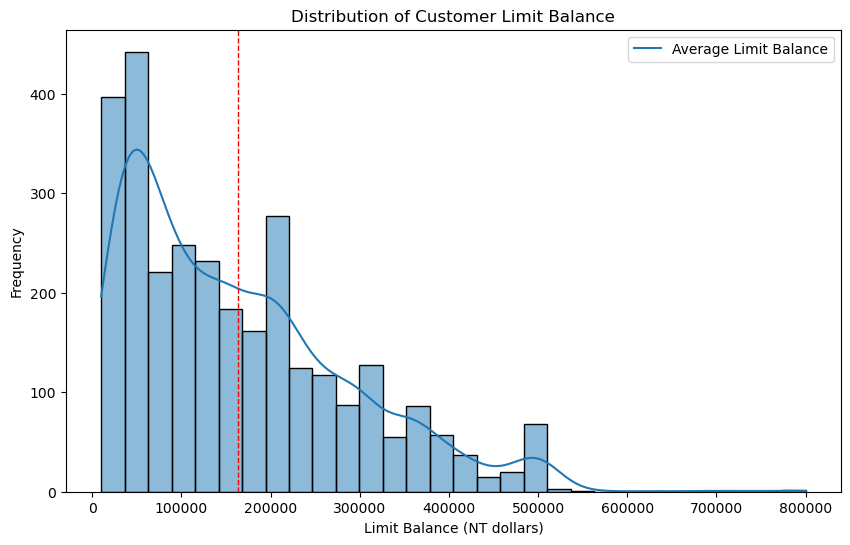

In [14]:
# Visualizing the distribution of limit balance with histogram 
plt.figure(figsize=(10, 6))
sns.histplot(df['limit_balance'], bins=30, kde=True)
plt.axvline(avg_limit_balance, color='r', linestyle='dashed', linewidth=1)
plt.xlabel('Limit Balance (NT dollars)')
plt.ylabel('Frequency')
plt.title('Distribution of Customer Limit Balance')
plt.legend({'Average Limit Balance': avg_limit_balance})
plt.show()

In [15]:
# Grouping new category based on above average of limit balance
df_group_2 = df.loc[df['limit_balance'] > avg_limit_balance].groupby('default_payment_next_month').size().reset_index().rename(columns={0:'count'})
df_group_2

,default_payment_next_month,count
0,0,1061
1,1,180


In [16]:
# Grouping new category based on less than average of limit balance
df_group_3 = df.loc[df['limit_balance'] < avg_limit_balance].groupby('default_payment_next_month').size().reset_index().rename(columns={0:'count'})
df_group_3

,default_payment_next_month,count
0,0,1269
1,1,455


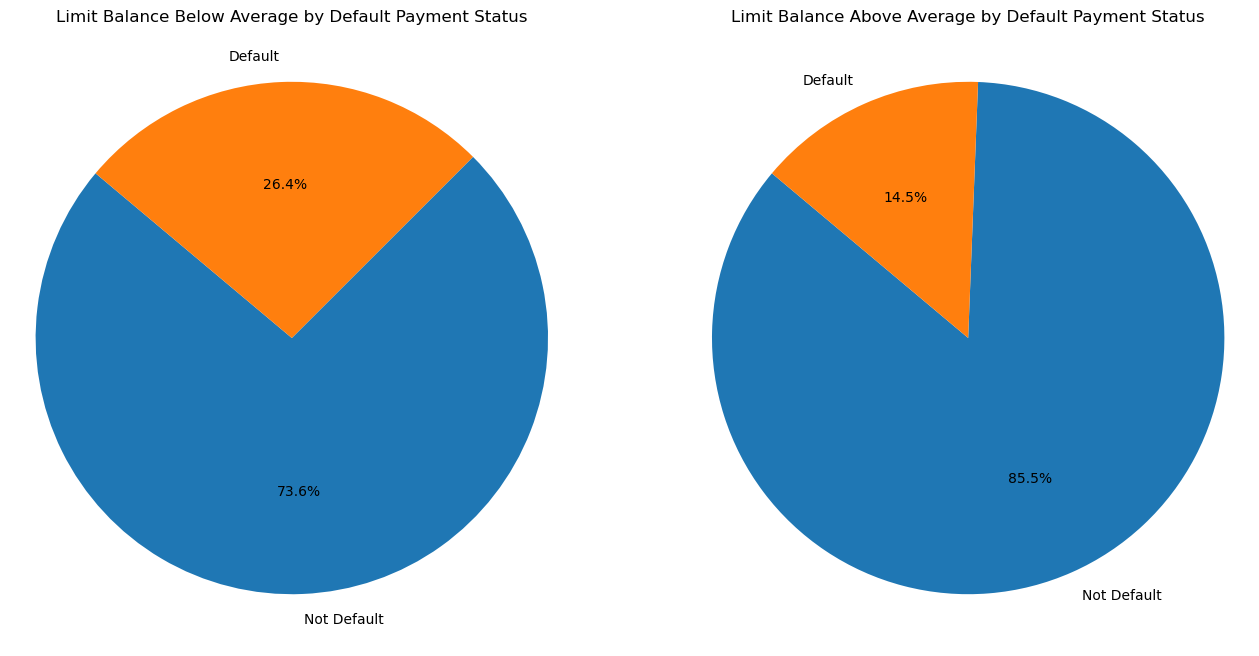

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# First pie chart for customers with credit limit below average
axs[0].pie(df_group_3['count'], labels=df_group_3['default_payment_next_month'].map({0: 'Not Default', 1:'Default'}), autopct='%1.1f%%', startangle=140)
axs[0].set_title('Limit Balance Below Average by Default Payment Status')
axs[0].axis('equal')

# Second pie chart for customers with credit limit above average
axs[1].pie(df_group_2['count'], labels=df_group_2['default_payment_next_month'].map({0: 'Not Default', 1: 'Default'}), autopct='%1.1f%%', startangle=140)
axs[1].set_title('Limit Balance Above Average by Default Payment Status')
axs[1].axis('equal')

plt.show()

Insight: 

- Customers with higher limit balance are less likely to default on their payments compared to those with lower credit limits.
- Customers with lower credit limits might need more monitoring and proactive measures to reduce the risk of default, such as early warnings or financial advice.
- For customers with higher credit limits, although the default rate is lower, it is still important to monitor their payment behavior as they constitute a significant portion of the bank’s credit exposure.

## c. Characteristics of credit card users (customers)

### By age

In [18]:
# checking statistical informations of age
df['age'].describe()

count    2965.000000
mean       35.193255
std         9.109439
min        21.000000
25%        28.000000
50%        34.000000
75%        41.000000
max        69.000000
Name: age, dtype: float64

In [19]:
# Calculating average of users' age
avg_age = df['age'].mean()
avg_age

35.19325463743676

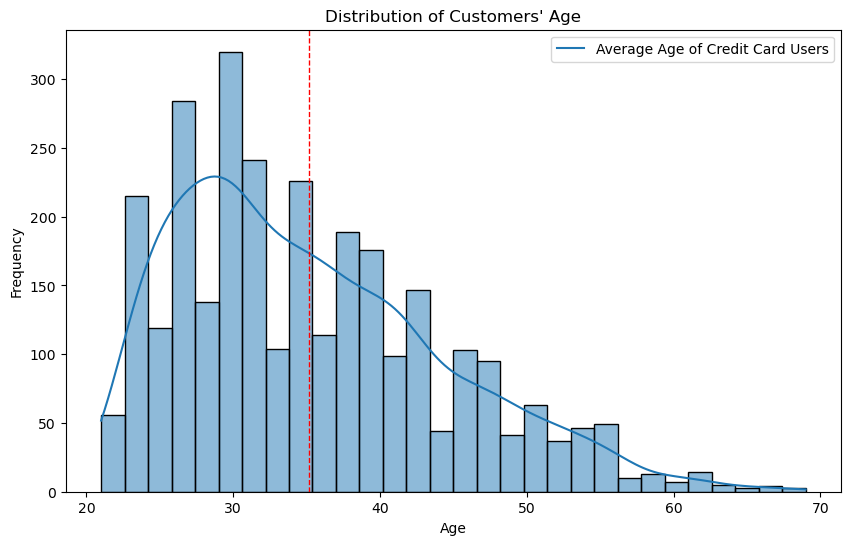

In [20]:
# Visualizing in histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.axvline(avg_age, color='r', linestyle='dashed', linewidth=1)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Customers\' Age')
plt.legend({'Average Age of Credit Card Users': avg_age})
plt.show()

Age distribution of credit card users with default payment status next month

In [21]:
# Determine age range 
bins = [20, 30, 40, 50, 60, 70]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69']

# Create a new column 'age_category' in order to analyzing based on age range
df['age_category'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

In [22]:
df['age_category']

0       50-59
1       40-49
2       20-29
3       30-39
4       30-39
        ...  
2960    20-29
2961    50-59
2962    30-39
2963    40-49
2964    30-39
Name: age_category, Length: 2965, dtype: category
Categories (5, object): ['20-29' < '30-39' < '40-49' < '50-59' < '60-69']

In [23]:
df_group_age = df.loc[df['default_payment_next_month'] == 1].groupby('age_category').size().reset_index(name='count')
df_group_age

/var/folders/5r/qgg84vr523s_9ksyqpjzvnfm0000gn/T/ipykernel_3073/2692735821.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_group_age = df.loc[df['default_payment_next_month'] == 1].groupby('age_category').size().reset_index(name='count')


,age_category,count
0,20-29,213
1,30-39,222
2,40-49,140
3,50-59,51
4,60-69,9


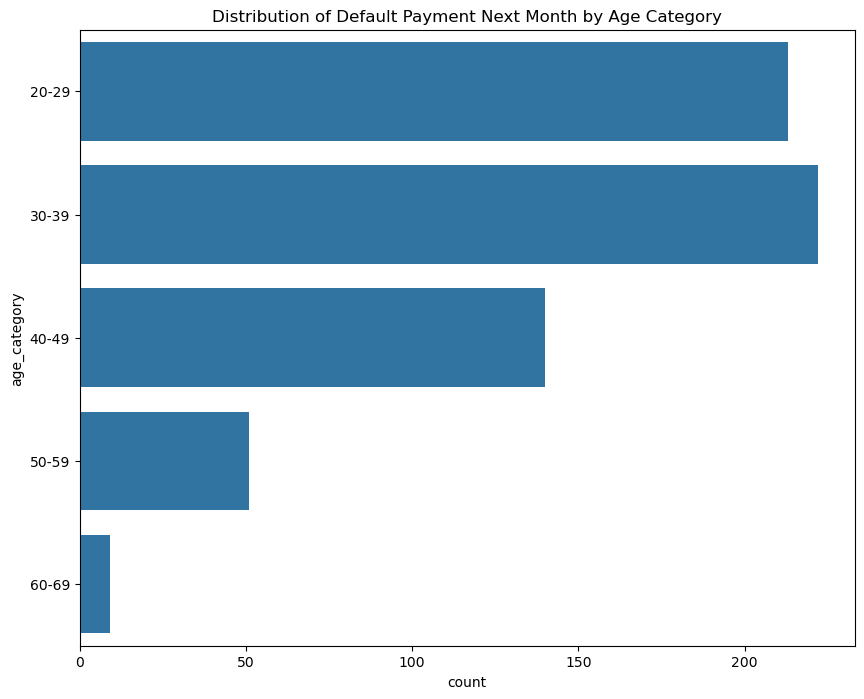

In [24]:
# Visualizing in bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x='count', y='age_category', data=df_group_age.sort_values(by='count',ascending=False), orient='h')
plt.title('Distribution of Default Payment Next Month by Age Category')
plt.show()

Insight: 

- younger credit card users (in range 20-29 and 30-39) are more likely to default on their payments compared to older age groups

- there is a clear decreasing trend in the number of defaulters as age increases. The number of marked as default significantly drops in the age groups 40-49 (140), 50-59 (51), and 60-69 (9)

In [25]:
# drop column age_category
del df['age_category']

### By gender

    1 = male
    
    2 = female

In [26]:
# Checking unique value of sex column
df['sex'].unique()

array([1, 2])

    1 = yes 

    0 = no

In [27]:
# checking unique value of default payment next month
df['default_payment_next_month'].unique()

array([1, 0])

In [28]:
# diplay count of credit card user with their default status payment next month
default_counts = df['default_payment_next_month'].value_counts().reset_index()
default_counts

,default_payment_next_month,count
0,0,2330
1,1,635


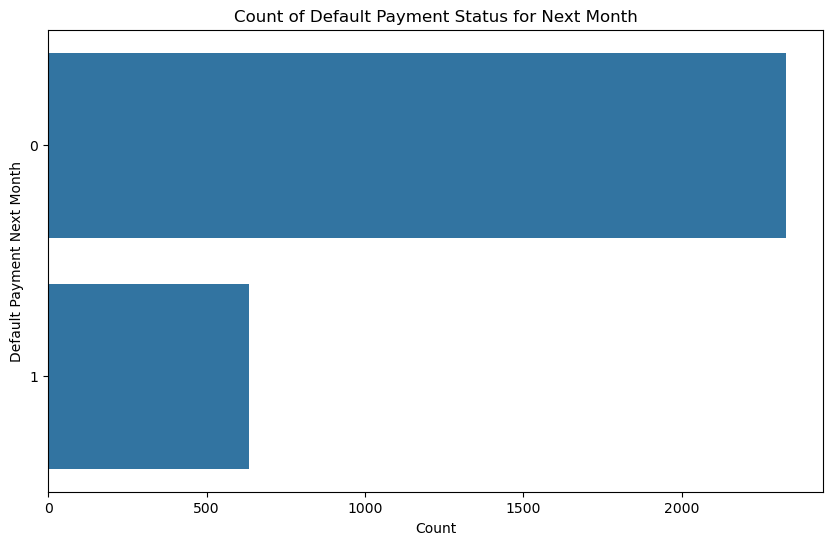

In [29]:
default_counts.columns = ['default_payment_next_month', 'count']

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='default_payment_next_month', data=default_counts, orient='h')
plt.xlabel('Count')
plt.ylabel('Default Payment Next Month')
plt.title('Count of Default Payment Status for Next Month')
plt.show()

Insight: 

- There are 635 credit card users with a default payment status next month in Total.

Which gender is more likely to default next month?

In [30]:
# Creating new table (dataframe) that provides count of customer's gender grouped by their default payment status for the next month.
df_group_4 = df.loc[df['default_payment_next_month'] == 1].groupby('sex').size().reset_index().rename(columns={0:'count'})
df_group_4

,sex,count
0,1,262
1,2,373


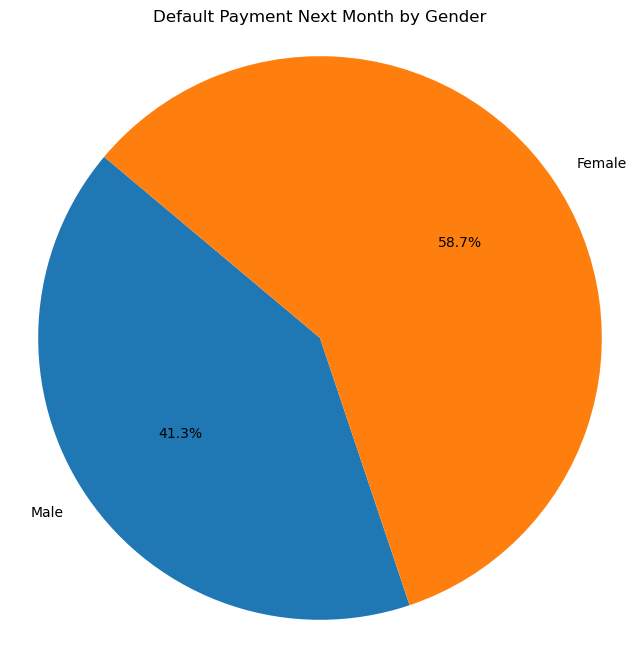

In [31]:
# Visualizing in pie chart
plt.figure(figsize=(8, 8))
plt.pie(df_group_4['count'], labels=df_group_4['sex'].map({1: 'Male', 2: 'Female'}), autopct='%1.1f%%', startangle=140)
plt.title('Default Payment Next Month by Gender')
plt.axis('equal')
plt.show()

Insight: 

- female customers have a higher tendency to default on their credit card payments compared to male customers in this dataset.

- the higher default rate among female customers could be influenced by various factors such as income levels, spending behavior, or access to financial management literature.

# 6. Feature Engineering

## Splitting Data into train dataset and test dataset

In [32]:
X = df.drop('default_payment_next_month', axis=1)
y = df[['default_payment_next_month']]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 2)

# Checking dimension of splitting data
print('Train size : ', X_train.shape)
print('Test size : ', X_test.shape)

Train size :  (2372, 23)
Test size :  (593, 23)


## Handling Missing Value

In [34]:
# checking missing value in train data 
X_train.isna().any()

limit_balance      False
sex                False
education_level    False
marital_status     False
age                False
pay_0              False
pay_2              False
pay_3              False
pay_4              False
pay_5              False
pay_6              False
bill_amt_1         False
bill_amt_2         False
bill_amt_3         False
bill_amt_4         False
bill_amt_5         False
bill_amt_6         False
pay_amt_1          False
pay_amt_2          False
pay_amt_3          False
pay_amt_4          False
pay_amt_5          False
pay_amt_6          False
dtype: bool

In [35]:
X_test.isna().any()

limit_balance      False
sex                False
education_level    False
marital_status     False
age                False
pay_0              False
pay_2              False
pay_3              False
pay_4              False
pay_5              False
pay_6              False
bill_amt_1         False
bill_amt_2         False
bill_amt_3         False
bill_amt_4         False
bill_amt_5         False
bill_amt_6         False
pay_amt_1          False
pay_amt_2          False
pay_amt_3          False
pay_amt_4          False
pay_amt_5          False
pay_amt_6          False
dtype: bool

## Handling Outliers

In [36]:
# define function to display outliers numbers on histogram and boxplot 
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

Age - Before Capping


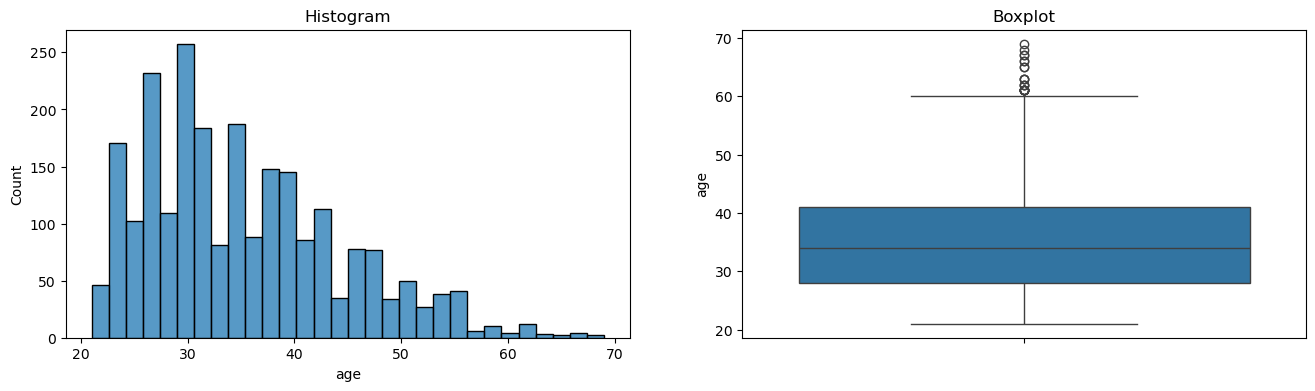

In [37]:
print('Age - Before Capping')
diagnostic_plots(X_train, 'age')

- checking skewness value to determine which technique to applied capping the outliers number

In [38]:
# Checking skewness value
skewness = X_train['age'].skew()
print(f'skewness value: {skewness}')

skewness value: 0.7687812537599771


- since the skewness value of age is 0.7687812537599771, which is below 1, I will use the capping skewed technique that uses 1.5 x IQR

In [39]:
# calculating q1, q3, iqr of age
q1 = X_train['age'].quantile(0.25)
q3 = X_train['age'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [40]:
# calculating the percentage of outliers number against the rest of  data
outliers = X_train['age'].loc[(X_train['age'] < lower_bound) | (X_train['age'] > upper_bound)]
outliers_percentage = len(outliers) / len(X_train) * 100
print(f'Number of outliers in Age: {len(outliers)}')
print(f'Percentage of outliers: {outliers_percentage:.5f}%')

Number of outliers in Age: 23
Percentage of outliers: 0.96965%


- the percentage number of outliers is less than 5%, so i decide to cap the age column.

In [41]:
# capping outliers number using winsorizor
winsorizered = Winsorizer(capping_method='iqr', tail='both', fold='auto', variables='age')
X_train['age'] = winsorizered.fit_transform(X_train[['age']])['age']

Age - After Capping


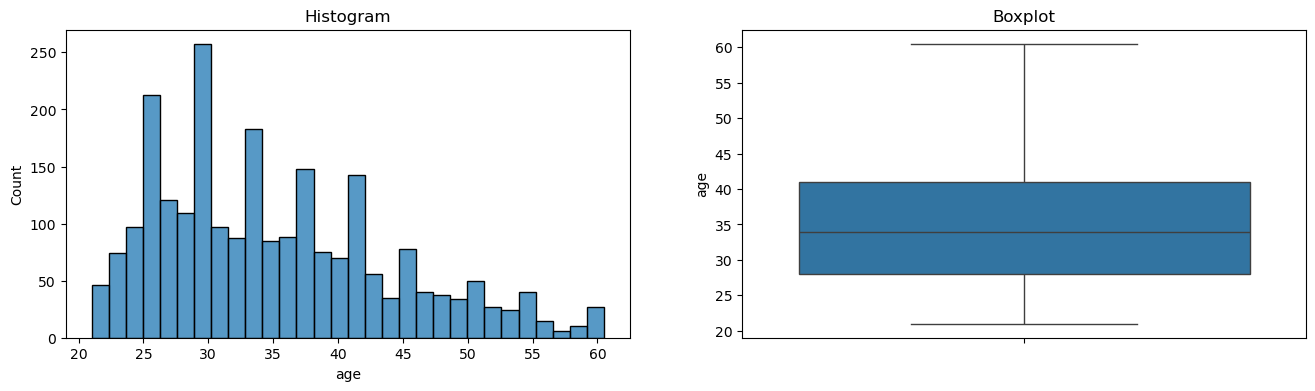

In [42]:
# Visualizing capped age data
print('Age - After Capping')
diagnostic_plots(X_train, 'age')


In [43]:
# Checking statistical informations after capping data 
X_train['age'].describe()

count    2372.000000
mean       35.092960
std         8.994474
min        21.000000
25%        28.000000
50%        34.000000
75%        41.000000
max        60.500000
Name: age, dtype: float64

**I assume that only the age feature requires outlier handling because ages above 60 are considered non-productive and have a lower likelihood of repayment**

The bill amount represents the exact number of customers billed, making it irrelevant to apply capping to this value. The pay amount represents the customer's ability to pay their monthly bills, making it irrelevant to apply capping to this value. These data points are not capped to ensure more accurate characteristics when making predictions (**to avoid data bias**).

## Feature Selection

In [44]:
X_train.columns

Index(['limit_balance', 'sex', 'education_level', 'marital_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6'],
      dtype='object')

### Checking Correlation between default status on repayment for the next month

In [45]:
# assigining new variable temporary contains combination of dataset feature and target
X_train_temp = pd.concat([y_train, X_train], axis=1)
X_train_temp.columns

Index(['default_payment_next_month', 'limit_balance', 'sex', 'education_level',
       'marital_status', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5',
       'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4',
       'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3',
       'pay_amt_4', 'pay_amt_5', 'pay_amt_6'],
      dtype='object')

In [46]:
# checking correlation with phik library and display it sorted from highest to lowest
correlation_matrix = X_train_temp.phik_matrix()
print(correlation_matrix['default_payment_next_month'].nlargest(23))

interval columns not set, guessing: ['default_payment_next_month', 'limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']


/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


default_payment_next_month    1.000000
pay_0                         0.452051
pay_6                         0.381236
pay_2                         0.353038
pay_3                         0.337063
pay_4                         0.331916
pay_5                         0.314612
limit_balance                 0.198295
bill_amt_1                    0.096121
education_level               0.081618
bill_amt_3                    0.080882
pay_amt_3                     0.075196
bill_amt_2                    0.075131
pay_amt_4                     0.057549
sex                           0.045280
pay_amt_1                     0.036400
bill_amt_4                    0.032055
marital_status                0.000000
age                           0.000000
bill_amt_5                    0.000000
bill_amt_6                    0.000000
pay_amt_2                     0.000000
pay_amt_5                     0.000000
Name: default_payment_next_month, dtype: float64


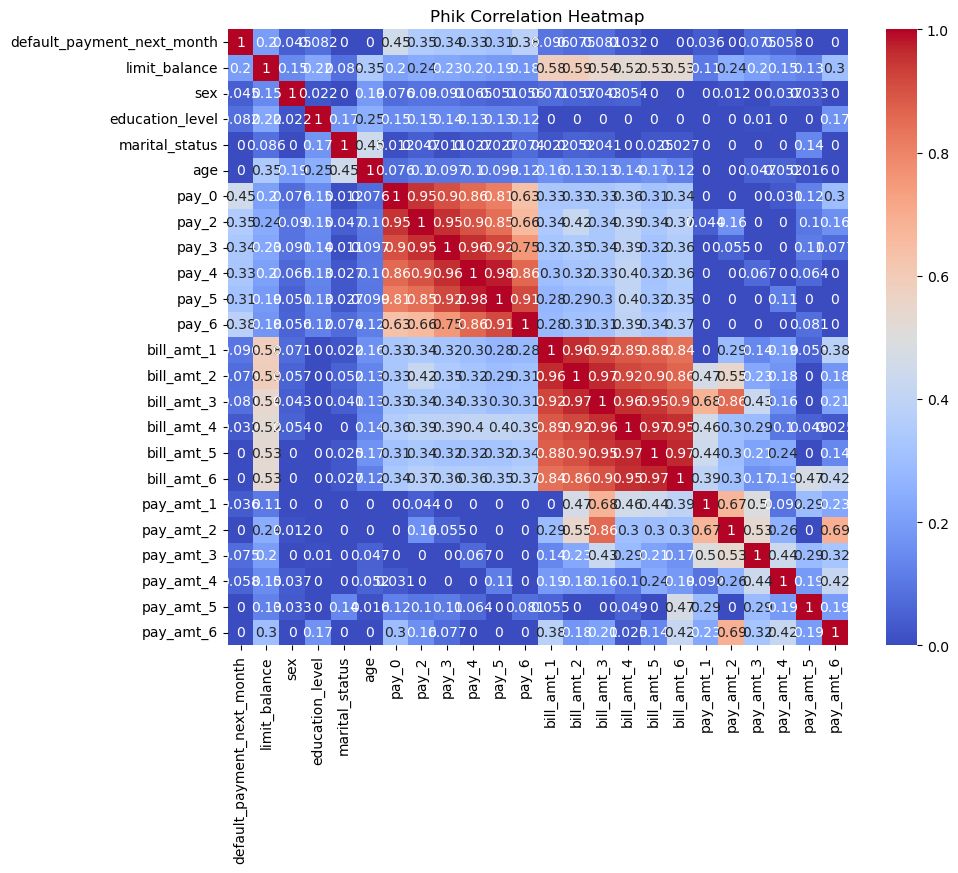

In [47]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Phik Correlation Heatmap')
plt.show()

### Converting Data type

- converting age data type into integer

In [48]:
X_train['age'] = X_train['age'].astype(int)
X_test['age'] = X_test['age'].astype(int)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2372 entries, 418 to 2575
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   limit_balance    2372 non-null   float64
 1   sex              2372 non-null   int64  
 2   education_level  2372 non-null   int64  
 3   marital_status   2372 non-null   int64  
 4   age              2372 non-null   int64  
 5   pay_0            2372 non-null   float64
 6   pay_2            2372 non-null   float64
 7   pay_3            2372 non-null   float64
 8   pay_4            2372 non-null   float64
 9   pay_5            2372 non-null   float64
 10  pay_6            2372 non-null   float64
 11  bill_amt_1       2372 non-null   float64
 12  bill_amt_2       2372 non-null   float64
 13  bill_amt_3       2372 non-null   float64
 14  bill_amt_4       2372 non-null   float64
 15  bill_amt_5       2372 non-null   float64
 16  bill_amt_6       2372 non-null   float64
 17  pay_amt_1        

- converting sex data type into object

    1 = male
    
    2 = female

In [49]:
X_train['sex'].unique()

array([1, 2])

In [50]:
# converting numerical data into object dtype as description data
X_train['sex'] = X_train['sex'].apply(lambda x: 'Male' if x == 1 else ('Female' if x == 2 else 'Other'))
X_test['sex'] = X_test['sex'].apply(lambda x: 'Male' if x == 1 else ('Female' if x == 2 else 'Other'))

In [51]:
X_train['sex'].unique()

array(['Male', 'Female'], dtype=object)

In [52]:
# converting into category dtypes
cat_sex_type = CategoricalDtype(categories=['Male', 'Female'])

X_train['sex'] = X_train['sex'].astype(cat_sex_type)
X_test['sex'] = X_test['sex'].astype(cat_sex_type)

In [53]:
X_train['sex'].unique()

['Male', 'Female']
Categories (2, object): ['Male', 'Female']

- converting education level data type into object data type

    1 = graduate school, 
    
    2 = university, 
    
    3 = high school, 
    
    4 = others, 
    
    5 = unknown, 
    
    6 = unknown.

In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2372 entries, 418 to 2575
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   limit_balance    2372 non-null   float64 
 1   sex              2372 non-null   category
 2   education_level  2372 non-null   int64   
 3   marital_status   2372 non-null   int64   
 4   age              2372 non-null   int64   
 5   pay_0            2372 non-null   float64 
 6   pay_2            2372 non-null   float64 
 7   pay_3            2372 non-null   float64 
 8   pay_4            2372 non-null   float64 
 9   pay_5            2372 non-null   float64 
 10  pay_6            2372 non-null   float64 
 11  bill_amt_1       2372 non-null   float64 
 12  bill_amt_2       2372 non-null   float64 
 13  bill_amt_3       2372 non-null   float64 
 14  bill_amt_4       2372 non-null   float64 
 15  bill_amt_5       2372 non-null   float64 
 16  bill_amt_6       2372 non-null   float64 
 17

In [55]:
X_train['education_level'].unique()

array([2, 3, 1, 5, 4, 6, 0])

In [56]:
# converting numerical data into object dtype as description data
X_train['education_level'] = X_train['education_level'].apply(lambda x: 'Graduate School' if x == 1 else('University' if x == 2 else('High School' if x == 3 else ('Others' if x == 4 else 'Unkown'))))
X_test['education_level'] = X_test['education_level'].apply(lambda x: 'Graduate School' if x == 1 else('University' if x == 2 else('High School' if x == 3 else ('Others' if x == 4 else 'Unkown'))))

In [57]:
X_train['education_level'].unique()

array(['University', 'High School', 'Graduate School', 'Unkown', 'Others'],
      dtype=object)

In [58]:
# converting into category dtypes
cat_education_type = CategoricalDtype(categories=['Unkown', 'High School', 'Graduate School', 'University', 'Others'], ordered=True)

X_train['education_level'] = X_train['education_level'].astype(cat_education_type)
X_test['education_level'] = X_test['education_level'].astype(cat_education_type)

In [59]:
X_train['education_level'].unique()

['University', 'High School', 'Graduate School', 'Unkown', 'Others']
Categories (5, object): ['Unkown' < 'High School' < 'Graduate School' < 'University' < 'Others']

- Converting marital status data type into object data type

    1 = married, 

    2 = single, 
    
    3 = others
    

In [60]:
X_train['marital_status'].unique()

array([1, 2, 0, 3])

In [61]:
# converting number into string as description data 
X_train['marital_status'] = X_train['marital_status'].apply(lambda x: "Married" if x == 1 else("Single" if x == 2 else "Others"))
X_test['marital_status'] = X_test['marital_status'].apply(lambda x: "Married" if x == 1 else("Single" if x == 2 else "Others"))

In [62]:
X_train['marital_status'].unique()

array(['Married', 'Single', 'Others'], dtype=object)

In [63]:
# converting into category dtypes
cat_marital_type = CategoricalDtype(categories=['Married', 'Single', 'Others'])

X_train['marital_status'] = X_train['marital_status'].astype(cat_marital_type)
X_test['marital_status'] = X_test['marital_status'].astype(cat_marital_type)

In [64]:
X_train['marital_status'].unique()

['Married', 'Single', 'Others']
Categories (3, object): ['Married', 'Single', 'Others']

- Converting age dtypes into category ordered

In [65]:
X_train['age'].unique()

array([41, 36, 30, 56, 44, 47, 27, 28, 43, 40, 31, 23, 52, 29, 26, 34, 42,
       25, 39, 24, 53, 60, 38, 35, 22, 45, 46, 32, 51, 54, 33, 37, 50, 21,
       49, 57, 48, 55, 59, 58])

In [66]:
unique_ages = X_train['age'].unique()

# Sort the array
sorted_ages = np.sort(unique_ages)
sorted_ages

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60])

- Converting pay_0 - pay_6 into category dtype

In [67]:
# converting numerical data type into object data type as description above
X_train['pay_0'] = X_train['pay_0'].apply(lambda x: "Pay Duly" if x == 1 else("No Late Payment" if x == 0 else("No Transaction" if x == -2 else("payment delay for one month" if x == 1 else("payment delay for two months" if x == 2 else("payment delay for three months" if x == 3 else("payment delay for four months" if x == 4 else("payment delay for five months" if x == 5 else("payment delay for six months" if x == 6 else ("payment delay for seven months" if x == 7 else("payment delay for eight months" if x == 8 else "payment delay for nine months and above")))))))))))
X_train['pay_2'] = X_train['pay_2'].apply(lambda x: "Pay Duly" if x == 1 else("No Late Payment" if x == 0 else("No Transaction" if x == -2 else("payment delay for one month" if x == 1 else("payment delay for two months" if x == 2 else("payment delay for three months" if x == 3 else("payment delay for four months" if x == 4 else("payment delay for five months" if x == 5 else("payment delay for six months" if x == 6 else ("payment delay for seven months" if x == 7 else("payment delay for eight months" if x == 8 else "payment delay for nine months and above")))))))))))
X_train['pay_3'] = X_train['pay_3'].apply(lambda x: "Pay Duly" if x == 1 else("No Late Payment" if x == 0 else("No Transaction" if x == -2 else("payment delay for one month" if x == 1 else("payment delay for two months" if x == 2 else("payment delay for three months" if x == 3 else("payment delay for four months" if x == 4 else("payment delay for five months" if x == 5 else("payment delay for six months" if x == 6 else ("payment delay for seven months" if x == 7 else("payment delay for eight months" if x == 8 else "payment delay for nine months and above")))))))))))
X_train['pay_4'] = X_train['pay_4'].apply(lambda x: "Pay Duly" if x == 1 else("No Late Payment" if x == 0 else("No Transaction" if x == -2 else("payment delay for one month" if x == 1 else("payment delay for two months" if x == 2 else("payment delay for three months" if x == 3 else("payment delay for four months" if x == 4 else("payment delay for five months" if x == 5 else("payment delay for six months" if x == 6 else ("payment delay for seven months" if x == 7 else("payment delay for eight months" if x == 8 else "payment delay for nine months and above")))))))))))
X_train['pay_5'] = X_train['pay_5'].apply(lambda x: "Pay Duly" if x == 1 else("No Late Payment" if x == 0 else("No Transaction" if x == -2 else("payment delay for one month" if x == 1 else("payment delay for two months" if x == 2 else("payment delay for three months" if x == 3 else("payment delay for four months" if x == 4 else("payment delay for five months" if x == 5 else("payment delay for six months" if x == 6 else ("payment delay for seven months" if x == 7 else("payment delay for eight months" if x == 8 else "payment delay for nine months and above")))))))))))
X_train['pay_6'] = X_train['pay_6'].apply(lambda x: "Pay Duly" if x == 1 else("No Late Payment" if x == 0 else("No Transaction" if x == -2 else("payment delay for one month" if x == 1 else("payment delay for two months" if x == 2 else("payment delay for three months" if x == 3 else("payment delay for four months" if x == 4 else("payment delay for five months" if x == 5 else("payment delay for six months" if x == 6 else ("payment delay for seven months" if x == 7 else("payment delay for eight months" if x == 8 else "payment delay for nine months and above")))))))))))

X_test['pay_0'] = X_test['pay_0'].apply(lambda x: "Pay Duly" if x == 1 else("No Late Payment" if x == 0 else("No Transaction" if x == -2 else("payment delay for one month" if x == 1 else("payment delay for two months" if x == 2 else("payment delay for three months" if x == 3 else("payment delay for four months" if x == 4 else("payment delay for five months" if x == 5 else("payment delay for six months" if x == 6 else ("payment delay for seven months" if x == 7 else("payment delay for eight months" if x == 8 else "payment delay for nine months and above")))))))))))
X_test['pay_2'] = X_test['pay_2'].apply(lambda x: "Pay Duly" if x == 1 else("No Late Payment" if x == 0 else("No Transaction" if x == -2 else("payment delay for one month" if x == 1 else("payment delay for two months" if x == 2 else("payment delay for three months" if x == 3 else("payment delay for four months" if x == 4 else("payment delay for five months" if x == 5 else("payment delay for six months" if x == 6 else ("payment delay for seven months" if x == 7 else("payment delay for eight months" if x == 8 else "payment delay for nine months and above")))))))))))
X_test['pay_3'] = X_test['pay_3'].apply(lambda x: "Pay Duly" if x == 1 else("No Late Payment" if x == 0 else("No Transaction" if x == -2 else("payment delay for one month" if x == 1 else("payment delay for two months" if x == 2 else("payment delay for three months" if x == 3 else("payment delay for four months" if x == 4 else("payment delay for five months" if x == 5 else("payment delay for six months" if x == 6 else ("payment delay for seven months" if x == 7 else("payment delay for eight months" if x == 8 else "payment delay for nine months and above")))))))))))
X_test['pay_4'] = X_test['pay_4'].apply(lambda x: "Pay Duly" if x == 1 else("No Late Payment" if x == 0 else("No Transaction" if x == -2 else("payment delay for one month" if x == 1 else("payment delay for two months" if x == 2 else("payment delay for three months" if x == 3 else("payment delay for four months" if x == 4 else("payment delay for five months" if x == 5 else("payment delay for six months" if x == 6 else ("payment delay for seven months" if x == 7 else("payment delay for eight months" if x == 8 else "payment delay for nine months and above")))))))))))
X_test['pay_5'] = X_test['pay_5'].apply(lambda x: "Pay Duly" if x == 1 else("No Late Payment" if x == 0 else("No Transaction" if x == -2 else("payment delay for one month" if x == 1 else("payment delay for two months" if x == 2 else("payment delay for three months" if x == 3 else("payment delay for four months" if x == 4 else("payment delay for five months" if x == 5 else("payment delay for six months" if x == 6 else ("payment delay for seven months" if x == 7 else("payment delay for eight months" if x == 8 else "payment delay for nine months and above")))))))))))
X_test['pay_6'] = X_test['pay_6'].apply(lambda x: "Pay Duly" if x == 1 else("No Late Payment" if x == 0 else("No Transaction" if x == -2 else("payment delay for one month" if x == 1 else("payment delay for two months" if x == 2 else("payment delay for three months" if x == 3 else("payment delay for four months" if x == 4 else("payment delay for five months" if x == 5 else("payment delay for six months" if x == 6 else ("payment delay for seven months" if x == 7 else("payment delay for eight months" if x == 8 else "payment delay for nine months and above")))))))))))

In [68]:
# defining category
cat_pay_type = CategoricalDtype(categories=['payment delay for nine months and above', 
                                            'payment delay for eight months', 
                                            'payment delay for seven months', 
                                            'payment delay for six months', 
                                            'payment delay for five months',
                                            'payment delay for four months',
                                            'payment delay for three months',
                                            'payment delay for two months',
                                            'payment delay for one month', 
                                            'No Transaction', 
                                            'No Late Payment', 
                                            'Pay Duly'])


In [69]:
# casting datatype category into pay feature
X_train['pay_0'] = X_train['pay_0'].astype(cat_pay_type)
X_train['pay_2'] = X_train['pay_2'].astype(cat_pay_type)
X_train['pay_3'] = X_train['pay_3'].astype(cat_pay_type)
X_train['pay_4'] = X_train['pay_4'].astype(cat_pay_type)
X_train['pay_5'] = X_train['pay_5'].astype(cat_pay_type)
X_train['pay_6'] = X_train['pay_6'].astype(cat_pay_type)

X_test['pay_0'] = X_test['pay_0'].astype(cat_pay_type)
X_test['pay_2'] = X_test['pay_2'].astype(cat_pay_type)
X_test['pay_3'] = X_test['pay_3'].astype(cat_pay_type)
X_test['pay_4'] = X_test['pay_4'].astype(cat_pay_type)
X_test['pay_5'] = X_test['pay_5'].astype(cat_pay_type)
X_test['pay_6'] = X_test['pay_6'].astype(cat_pay_type)

### Splitting data by dtypes

In [70]:
# assigning a new variable based on relevance feature
num_cols = X_train.select_dtypes(include=float).columns.tolist()
cat_cols_ordinal = ['education_level', 'age']
cat_cols_nominal = ['sex', 'marital_status', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

In [71]:
print(f'numerical columns   : {num_cols}')
print(f'categorical columns ordinal: {cat_cols_ordinal}')
print(f'categorical columns nominal: {cat_cols_nominal}')

numerical columns   : ['limit_balance', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']
categorical columns ordinal: ['education_level', 'age']
categorical columns nominal: ['sex', 'marital_status', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


In [72]:
X_train_num = X_train[num_cols]
X_test_num = X_test[num_cols]

X_train_ord = X_train[cat_cols_ordinal]
X_test_ord = X_test[cat_cols_ordinal]

X_train_nom = X_train[cat_cols_nominal]
X_test_nom = X_test[cat_cols_nominal]

    1 = yes 
    
    0 = no

## Determine Scaler Method by Checking Statistics Value of Numerical Data

In [73]:
# Iteratting statistical informations numerical data type 
for column in num_cols:
    skewness_train = X_train_num[column].skew()
    min_train = X_train_num[column].min()
    max_train = X_train_num[column].max()
    range_train = X_train_num[column].max() - X_train_num[column].min()
    print(f'skewness value of feature {column}: {skewness_train}')
    print(f'minimum value of feature {column}: {min_train}')
    print(f'maximum value of feature {column}: {max_train}')
    print(f'range value of feature {column}: {range_train}\n')


skewness value of feature limit_balance: 1.0221839948837748
minimum value of feature limit_balance: 10000.0
maximum value of feature limit_balance: 800000.0
range value of feature limit_balance: 790000.0

skewness value of feature bill_amt_1: 2.657055179541352
minimum value of feature bill_amt_1: -11545.0
maximum value of feature bill_amt_1: 613860.0
range value of feature bill_amt_1: 625405.0

skewness value of feature bill_amt_2: 2.605841490536787
minimum value of feature bill_amt_2: -67526.0
maximum value of feature bill_amt_2: 512650.0
range value of feature bill_amt_2: 580176.0

skewness value of feature bill_amt_3: 2.6431486907677657
minimum value of feature bill_amt_3: -9850.0
maximum value of feature bill_amt_3: 559712.0
range value of feature bill_amt_3: 569562.0

skewness value of feature bill_amt_4: 2.581191828795603
minimum value of feature bill_amt_4: -27490.0
maximum value of feature bill_amt_4: 488808.0
range value of feature bill_amt_4: 516298.0

skewness value of featu

**Due the value of numeric columns have similar range in scale and huge skewness value, determine to use MinMaxScaler preprocessing library to conduct scaling numeric data**

In [74]:
scaler = MinMaxScaler()

## Preprocessing with Pipeline

In [75]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2372 entries, 418 to 2575
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   limit_balance    2372 non-null   float64 
 1   sex              2372 non-null   category
 2   education_level  2372 non-null   category
 3   marital_status   2372 non-null   category
 4   age              2372 non-null   int64   
 5   pay_0            2372 non-null   category
 6   pay_2            2372 non-null   category
 7   pay_3            2372 non-null   category
 8   pay_4            2372 non-null   category
 9   pay_5            2372 non-null   category
 10  pay_6            2372 non-null   category
 11  bill_amt_1       2372 non-null   float64 
 12  bill_amt_2       2372 non-null   float64 
 13  bill_amt_3       2372 non-null   float64 
 14  bill_amt_4       2372 non-null   float64 
 15  bill_amt_5       2372 non-null   float64 
 16  bill_amt_6       2372 non-null   float64 
 17

In [76]:
edu_categories_list = ['Unkown', 'High School', 'Graduate School', 'University', 'Others']

In [77]:
# pipeline for scaler
numerical_pipe = Pipeline([
    ('imputasi', SimpleImputer(strategy='median')),
    ('scaler', scaler)
])


encoder = OrdinalEncoder(categories=[edu_categories_list, sorted_ages.tolist()], handle_unknown='use_encoded_value', unknown_value=-1)
# pipeline for ordinal encoder
categorical_ordinal_pipe = Pipeline([
    ('imputasi_ord', SimpleImputer(strategy='most_frequent')),
    ('enc',encoder)
])


ohe = OneHotEncoder(handle_unknown='ignore')

# pipeline for nominal encoder
categorical_nominal_pipe = Pipeline([
    ('imputasi_nom', SimpleImputer(strategy='most_frequent')),
    ('ohe',ohe)
    ])

# make a pipeline for preprocessing data
preprocessing = ColumnTransformer([
    ('numerical', numerical_pipe, num_cols), 
    ('nominal', categorical_nominal_pipe, cat_cols_nominal),
    ('ordinal', categorical_ordinal_pipe, cat_cols_ordinal)
], remainder='drop')



In [78]:
pd.DataFrame(preprocessing.fit_transform(X_train), columns= preprocessing.get_feature_names_out())

,numerical__limit_balance,numerical__bill_amt_1,numerical__bill_amt_2,numerical__bill_amt_3,numerical__bill_amt_4,numerical__bill_amt_5,numerical__bill_amt_6,numerical__pay_amt_1,numerical__pay_amt_2,numerical__pay_amt_3,...,nominal__pay_6_No Late Payment,nominal__pay_6_No Transaction,nominal__pay_6_payment delay for four months,nominal__pay_6_payment delay for nine months and above,nominal__pay_6_payment delay for seven months,nominal__pay_6_payment delay for six months,nominal__pay_6_payment delay for three months,nominal__pay_6_payment delay for two months,ordinal__education_level,ordinal__age
0,0.367089,0.279144,0.358508,0.186255,0.178137,0.239933,0.293983,0.011158,0.004075,0.015060,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,20.0
1,0.113924,0.080094,0.189294,0.092152,0.139877,0.125583,0.245627,0.008918,0.000838,0.015662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,15.0
2,0.113924,0.019921,0.118405,0.017294,0.053244,0.019982,0.144873,0.002990,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.0
3,0.012658,0.050078,0.142226,0.041999,0.083289,0.054098,0.186256,0.004072,0.001630,0.010040,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,35.0
4,0.253165,0.159663,0.271092,0.175365,0.190103,0.174514,0.285725,0.009121,0.002934,0.015562,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2367,0.443038,0.019707,0.116389,0.017979,0.054000,0.016941,0.145638,0.000000,0.000318,0.001958,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,17.0
2368,0.126582,0.021157,0.117078,0.017821,0.055030,0.023885,0.148753,0.000811,0.000244,0.004628,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0
2369,0.037975,0.019260,0.116389,0.049921,0.090729,0.059350,0.184631,0.000000,0.015144,0.007329,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0
2370,0.392405,0.078199,0.153957,0.036252,0.071060,0.021224,0.173295,0.044396,0.008827,0.046404,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,24.0


In [79]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2372 entries, 418 to 2575
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   limit_balance    2372 non-null   float64 
 1   sex              2372 non-null   category
 2   education_level  2372 non-null   category
 3   marital_status   2372 non-null   category
 4   age              2372 non-null   int64   
 5   pay_0            2372 non-null   category
 6   pay_2            2372 non-null   category
 7   pay_3            2372 non-null   category
 8   pay_4            2372 non-null   category
 9   pay_5            2372 non-null   category
 10  pay_6            2372 non-null   category
 11  bill_amt_1       2372 non-null   float64 
 12  bill_amt_2       2372 non-null   float64 
 13  bill_amt_3       2372 non-null   float64 
 14  bill_amt_4       2372 non-null   float64 
 15  bill_amt_5       2372 non-null   float64 
 16  bill_amt_6       2372 non-null   float64 
 17

- creating pipeline for each model to conduct cross validation and choose which model has the best average of f-1 score

In [80]:
# creating pipeline for the models
pipe_log = make_pipeline(preprocessing, LogisticRegression())
pipe_knn = make_pipeline(preprocessing, KNeighborsClassifier())
pipe_svc = make_pipeline(preprocessing, SVC())

In [81]:
# pipeline for scorring
cv_log = cross_val_score(pipe_log, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
cv_knn = cross_val_score(pipe_knn, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
cv_svc = cross_val_score(pipe_svc, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)

/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was pass

In [82]:
pipe_log

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance',
                                                   'bill_amt_1', 'bill_amt_2',
                                                   'bill_amt_3', 'bill_amt_4',
                                                   'bill_amt_5', 'bill_amt_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5', 'pay_amt_6']),
                                                 ('nominal...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   OrdinalEncoder(categories=[['Unkown',
                                                                                               'High '
                                                                                               'School',
                                                                                               'Graduate '
                                                                                               'School',
                                                                                               'University',
                                                                                               'Others'],
                                                                                              [21,
                                                                                               22,
                                                                                               23,
                                                                                               24,
                                                                                               25,
                                                                                               26,
                                                                                               27,
                                                                                               28,
                                                                                               29,
                                                                                               30,
                                                                                               31,
                                                                                               32,
                                                                                               33,
                                                                                               34,
                                                                                               35,
                                                                                               36,
                                                                                               37,
                                                                                               38,
                                                                                               39,
                                                                                               40,
                                                    

In [83]:
pipe_knn

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance',
                                                   'bill_amt_1', 'bill_amt_2',
                                                   'bill_amt_3', 'bill_amt_4',
                                                   'bill_amt_5', 'bill_amt_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5', 'pay_amt_6']),
                                                 ('nominal...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   OrdinalEncoder(categories=[['Unkown',
                                                                                               'High '
                                                                                               'School',
                                                                                               'Graduate '
                                                                                               'School',
                                                                                               'University',
                                                                                               'Others'],
                                                                                              [21,
                                                                                               22,
                                                                                               23,
                                                                                               24,
                                                                                               25,
                                                                                               26,
                                                                                               27,
                                                                                               28,
                                                                                               29,
                                                                                               30,
                                                                                               31,
                                                                                               32,
                                                                                               33,
                                                                                               34,
                                                                                               35,
                                                                                               36,
                                                                                               37,
                                                                                               38,
                                                                                               39,
                                                                                               40,
                                                    

In [84]:
pipe_svc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance',
                                                   'bill_amt_1', 'bill_amt_2',
                                                   'bill_amt_3', 'bill_amt_4',
                                                   'bill_amt_5', 'bill_amt_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5', 'pay_amt_6']),
                                                 ('nominal...
                                                  Pipeline(steps=[('imputasi_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   OrdinalEncoder(categories=[['Unkown',
                                                                                               'High '
                                                                                               'School',
                                                                                               'Graduate '
                                                                                               'School',
                                                                                               'University',
                                                                                               'Others'],
                                                                                              [21,
                                                                                               22,
                                                                                               23,
                                                                                               24,
                                                                                               25,
                                                                                               26,
                                                                                               27,
                                                                                               28,
                                                                                               29,
                                                                                               30,
                                                                                               31,
                                                                                               32,
                                                                                               33,
                                                                                               34,
                                                                                               35,
                                                                                               36,
                                                                                               37,
                                                                                               38,
                                                                                               39,
                                                                    

- checking which model will used by conducting cross validation

In [85]:
name_model = []
cv_score = 0
for cv, name in zip([cv_log, cv_knn, cv_svc],
                    ['log','knn','svc']):
    print(name)
    print(f'f1 - All - Cross Validation: {cv}')
    print(f'f1 - mean - Cross Validation: {cv.mean()}')
    print(f'f1 - std - Cross Validation: {cv.std()}')
    print(f'f1 - range - Cross Validation: {cv.mean()-cv.std()} - {cv.mean()+cv.std()}')
    print('-'*50)

    if cv_score < cv.mean():
        cv_score = cv.mean()
        best_model = name
    else:
      pass

print(f'Cross Val mean from best model: {cv_score}')
print(f'Best Model: {best_model}')


log
f1 - All - Cross Validation: [0.56441718 0.48407643 0.45637584 0.54658385 0.47798742]
f1 - mean - Cross Validation: 0.5058881444553258
f1 - std - Cross Validation: 0.04192244692594762
f1 - range - Cross Validation: 0.4639656975293782 - 0.5478105913812734
--------------------------------------------------
knn
f1 - All - Cross Validation: [0.39215686 0.30985915 0.33576642 0.36111111 0.29530201]
f1 - mean - Cross Validation: 0.33883911311325393
f1 - std - Cross Validation: 0.034881464329174015
f1 - range - Cross Validation: 0.30395764878407994 - 0.3737205774424279
--------------------------------------------------
svc
f1 - All - Cross Validation: [0.16216216 0.10619469 0.16071429 0.14678899 0.14035088]
f1 - mean - Cross Validation: 0.14324220123212103
f1 - std - Cross Validation: 0.020281499933138124
f1 - range - Cross Validation: 0.1229607012989829 - 0.16352370116525916
--------------------------------------------------
Cross Val mean from best model: 0.5058881444553258
Best Model: l

# 7. Model Definition

- defining best model based on cross validation result

In [86]:
model_log = LogisticRegression()
model_log

LogisticRegression()

- creating pipeline for process data processing and modeling

In [87]:
pipe_logreg = Pipeline([['feature engineering', preprocessing], ['log_reg', model_log]])

In [88]:
pipe_logreg

Pipeline(steps=[['feature engineering',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance',
                                                   'bill_amt_1', 'bill_amt_2',
                                                   'bill_amt_3', 'bill_amt_4',
                                                   'bill_amt_5', 'bill_amt_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5', 'pay_amt_6']),
                                                 ('nomina...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   OrdinalEncoder(categories=[['Unkown',
                                                                                               'High '
                                                                                               'School',
                                                                                               'Graduate '
                                                                                               'School',
                                                                                               'University',
                                                                                               'Others'],
                                                                                              [21,
                                                                                               22,
                                                                                               23,
                                                                                               24,
                                                                                               25,
                                                                                               26,
                                                                                               27,
                                                                                               28,
                                                                                               29,
                                                                                               30,
                                                                                               31,
                                                                                               32,
                                                                                               33,
                                                                                               34,
                                                                                               35,
                                                                                               36,
                                                                                               37,
                                                                                               38,
                                                                                               39,
                                                                                               40,
                                                   

**Advantages:**

- Interpretable: Logistic Regression produces coefficients that are easy to interpret, allowing us to understand the influence of each feature on the probability of default.
- Probabilistic Output: This model provides default probabilities that can be used for risk-based decision making.
- Handles Large Datasets Well: The model is scalable and can handle large datasets effectively.


**Disadvantages:**

- Logistic Regression assumes a linear relationship between the features and the log-odds of the outcome. If this relationship is not linear, the model's performance may decline.

*Logistic Regression is usually the most suitable model due to its ease of interpretation, efficiency, and good performance in binary classification problems (default or not).*

# 8. Model Training

In [89]:
# training model with train dataset with default parameter
pipe_logreg.fit(X_train, y_train)

/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('feature engineering',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance',
                                                   'bill_amt_1', 'bill_amt_2',
                                                   'bill_amt_3', 'bill_amt_4',
                                                   'bill_amt_5', 'bill_amt_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5', 'pay_amt_6']),
                                                 ('nomina...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   OrdinalEncoder(categories=[['Unkown',
                                                                                               'High '
                                                                                               'School',
                                                                                               'Graduate '
                                                                                               'School',
                                                                                               'University',
                                                                                               'Others'],
                                                                                              [21,
                                                                                               22,
                                                                                               23,
                                                                                               24,
                                                                                               25,
                                                                                               26,
                                                                                               27,
                                                                                               28,
                                                                                               29,
                                                                                               30,
                                                                                               31,
                                                                                               32,
                                                                                               33,
                                                                                               34,
                                                                                               35,
                                                                                               36,
                                                                                               37,
                                                                                               38,
                                                                                               39,
                                                                                               40,
                                                   

# 9. Evaluate Model

In [90]:
# predicting data with a feature dataset that generates a prediction stored (assigned new variable) in a variable prediction
y_pred_train = pipe_logreg.predict(X_train)
y_pred_test = pipe_logreg.predict(X_test)

## Confussion Matrix

In [91]:
matrix = confusion_matrix(y_test, y_pred_test)
matrix

array([[443,  22],
       [ 70,  58]])

In [92]:
tn, fp, fn, tp = matrix.ravel()

print(f'TN: {tn}')
print(f'FP: {fp}')
print(f'FN: {fn}')
print(f'TP: {tp}')

TN: 443
FP: 22
FN: 70
TP: 58


- Checking Performance Model against Train-Set


F1 Score - Train Set  :  0.5240506329113924 

Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.96      0.90      1865
           1       0.73      0.41      0.52       507

    accuracy                           0.84      2372
   macro avg       0.79      0.68      0.71      2372
weighted avg       0.83      0.84      0.82      2372
 

Confusion Matrix      : 


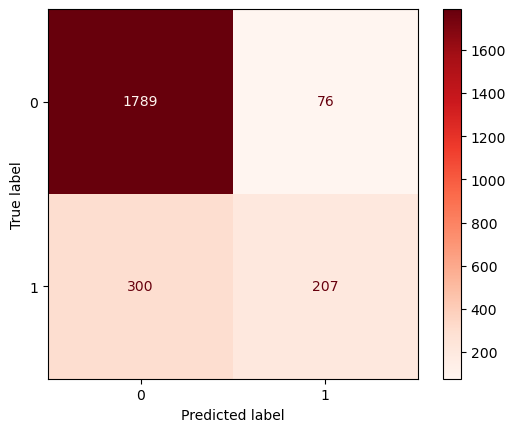

In [93]:
print('F1 Score - Train Set  : ', f1_score(y_train, y_pred_train), '\n')
print('Classification Report : \n', classification_report(y_train, y_pred_train), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_logreg, X_train, y_train, cmap
                                                                          ='Reds'))

- Checking Performance Model against Test-Set


F1 Score - Test Set  :  0.5576923076923077 

Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.95      0.91       465
           1       0.72      0.45      0.56       128

    accuracy                           0.84       593
   macro avg       0.79      0.70      0.73       593
weighted avg       0.83      0.84      0.83       593
 

Confusion Matrix      : 


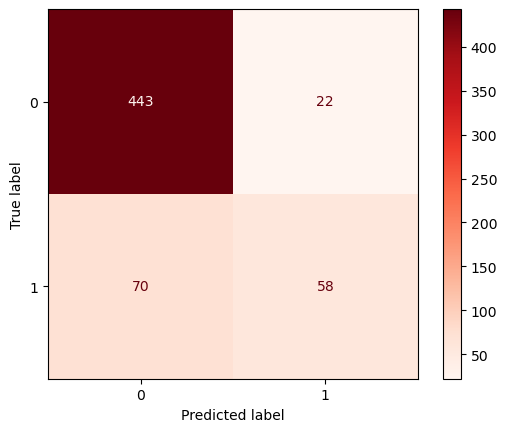

In [94]:
print('F1 Score - Test Set  : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_logreg, X_test, y_test, cmap='Reds'))

In [95]:
all_reports = {}
def performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, name):
  score_reports = {
      'train - f1_score' : f1_score(y_train, y_pred_train),
      'test - f1_score' : f1_score(y_test, y_pred_test),
  }
  all_reports[name] = score_reports
  return all_reports

In [96]:
all_reports = performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, 'Baseline (Default Hyperparameter)')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter)
train - f1_score,0.524051
test - f1_score,0.557692


## Hyperparameter Tuning

### Grid Search

In [97]:
grid_search_params = {
    'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'log_reg__penalty': ['l1','l2','elacticnet', None],
    'log_reg__random_state': [12,13,34,45]
    }

clf_grid = GridSearchCV(pipe_logreg, param_grid=grid_search_params, cv=5, scoring='f1', n_jobs=-1)

In [98]:
clf_grid.fit(X_train, y_train)

/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was pass

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature engineering',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputasi',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['limit_balance',
                                                                          'bill_amt_1',
                                                                          'bill_amt_2',
                                                                          'bill_amt_3',
                                                                          'bill_amt_4',
                                                                          'bill_amt_5',
                                                                          'bill_amt_6',
                                                                          'pay_amt_1',
                                                                          'pay_amt_2',
                                                                          'pay_amt_3',
                                                                          'pay_amt_4',
                                                                          'pay_a...
                                                                                                                      30,
                                                                                                                      31,
                                                                                                                      32,
                                                                                                                      33,
                                                                                                                      34,
                                                                                                                      35,
                                                                                                                      36,
                                                                                                                      37,
                                                                                                                      38,
                                                                                                                      39,
                                                                                                                      40,
                                                                                                                      41,
                                                                                                                      42,
                                                                                                                      43,
                                                                                                                      44,
                                                                                                                      45,
                                                                                                                      46,
                                                                                                                      47,
                                                                                                                      48,
                           

In [99]:
best_params = clf_grid.best_params_
best_params

{'log_reg__C': 0.001, 'log_reg__penalty': None, 'log_reg__random_state': 12}

In [100]:
best_estimator = clf_grid.best_estimator_
best_estimator

Pipeline(steps=[('feature engineering',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance',
                                                   'bill_amt_1', 'bill_amt_2',
                                                   'bill_amt_3', 'bill_amt_4',
                                                   'bill_amt_5', 'bill_amt_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5', 'pay_amt_6']),
                                                 ('nomina...
                                                                  ('enc',
                                                                   OrdinalEncoder(categories=[['Unkown',
                                                                                               'High '
                                                                                               'School',
                                                                                               'Graduate '
                                                                                               'School',
                                                                                               'University',
                                                                                               'Others'],
                                                                                              [21,
                                                                                               22,
                                                                                               23,
                                                                                               24,
                                                                                               25,
                                                                                               26,
                                                                                               27,
                                                                                               28,
                                                                                               29,
                                                                                               30,
                                                                                               31,
                                                                                               32,
                                                                                               33,
                                                                                               34,
                                                                                               35,
                                                                                               36,
                                                                                               37,
                                                                                               38,
                                                                                               39,
                                                                                               40,
                                                                                               41,
                                                             

In [101]:
# Get result from a particular step such as coefficients and intercept from Logistic Regression

print('Coefficient : ', best_estimator.named_steps['log_reg'].coef_)
print('Intercept   : ', best_estimator.named_steps['log_reg'].intercept_)

Coefficient :  [[-1.93567603  0.51683488  1.00967482  0.31092848 -0.41589877 -0.06344335
  -0.4153482  -0.45960346 -0.38965116 -1.65483436 -0.51298538 -0.86843123
  -1.46417567 -0.06938767 -0.1327501   0.41874199 -0.94359449  0.32271473
  -1.5999766  -0.60684356 -0.28576784  0.114947   -0.45179447 -0.20519804
  -1.1406788   0.23157234  2.78702027  0.95458192  0.6595267  -0.27189327
  -0.73083804 -0.92539737 -0.00364814  0.114947    0.23157234  0.54701654
   0.17657648 -0.483848   -0.20730244  0.43135652 -0.27796523 -0.11645659
   0.23767211  0.25071602 -0.19712876  0.16081859 -0.57665    -0.14845183
   0.07735415  0.9225581  -0.16439325 -0.01102718  0.13576902 -0.34550709
  -0.09178968 -0.1651436  -0.44617247  0.26970213 -0.18208652 -0.61232338
  -0.01102718  0.13576902  0.58992761  0.21921663 -0.33862788 -0.15187615
   0.26642037 -0.13582289 -0.01102718  0.25210409 -0.23059982  0.14729169
   0.18019347  0.00935145]]
Intercept   :  [-0.20213777]


__Insgiht:__

- Coefficients in logistic regression are values that represent the influence of each variable (feature) on the logit of the probability of the outcome.

- Positive Coefficient: feature's value will __increase__ the logit of the probability of the outcome, which directly increases the probability of the outcome.

- Negative Coefficient: feature's value will __decrease__ the logit of the probability of the outcome, which directly decreases the probability of the outcome.

- There shows that an increase of one unit in the first feature will decrease the logit of the probability of the outcome by 1.93567603.

- an Intercept of -0.20213777 indicates that when all features are zero, the logit of the probability of the outcome is -0.20213777 (treat as based line of the logit probability)

F1 Score - Train Set  :  0.5208596713021492 

Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.96      0.90      1865
           1       0.73      0.41      0.52       507

    accuracy                           0.84      2372
   macro avg       0.79      0.68      0.71      2372
weighted avg       0.83      0.84      0.82      2372
 

Confusion Matrix      : 


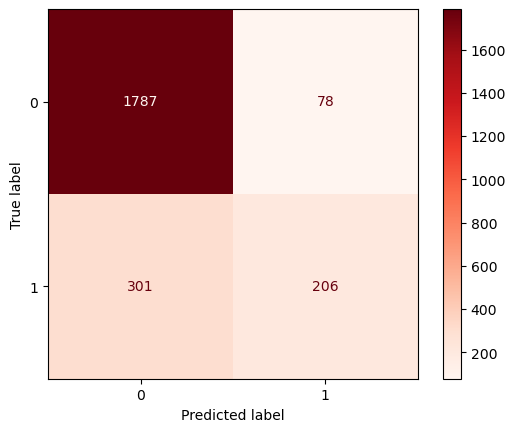

In [102]:
y_pred_train_grid = best_estimator.predict(X_train)

print('F1 Score - Train Set  : ', f1_score(y_train, y_pred_train_grid), '\n')
print('Classification Report : \n', classification_report(y_train, y_pred_train_grid), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_estimator, X_train, y_train, cmap='Reds'))

F1 Score - Test Set  :  0.5365853658536586 

Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       465
           1       0.71      0.43      0.54       128

    accuracy                           0.84       593
   macro avg       0.79      0.69      0.72       593
weighted avg       0.83      0.84      0.82       593
 

Confusion Matrix      : 


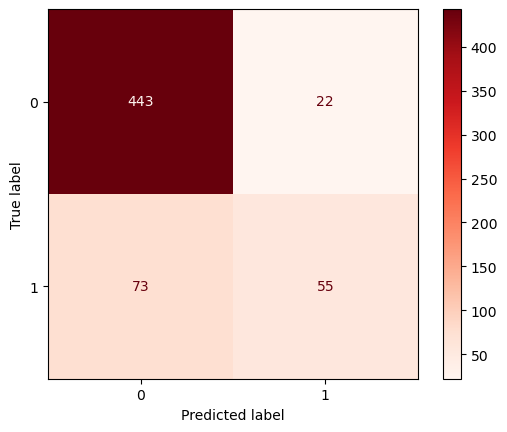

In [103]:
y_pred_test_grid = best_estimator.predict(X_test)

print('F1 Score - Test Set  : ', f1_score(y_test, y_pred_test_grid), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test_grid), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, y_test, cmap='Reds'))

In [104]:
all_reports = performance_report(all_reports, y_train, y_pred_train_grid, y_test, y_pred_test_grid, 'Grid Search')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter),Grid Search
train - f1_score,0.524051,0.520860
test - f1_score,0.557692,0.536585


## Evaluating The Characteristics Data

In [105]:
# create table to evaluate and analyze data
evaluation = X_test
evaluation['label'] = y_test
evaluation['pred_before'] = y_pred_test
evaluation['pred_tuned'] = y_pred_test_grid

In [106]:
# define TP, TN, FN, and FP for before tuning

# model succeed to predict 
tp_before = evaluation.loc[(evaluation['label']==1)&(evaluation['pred_before']==1)]
tn_before = evaluation.loc[(evaluation['label']==0)&(evaluation['pred_before']==0)]

# fail to predict
fn_before = evaluation.loc[(evaluation['label']==1)&(evaluation['pred_before']==0)]
fp_before = evaluation.loc[(evaluation['label']==0)&(evaluation['pred_before']==1)]

In [107]:
# define TP, TN, FN, and FP for after tuning
# as predicted
tp_tuned = evaluation.loc[(evaluation['label']==1)&(evaluation['pred_tuned']==1)]
tn_tuned = evaluation.loc[(evaluation['label']==0)&(evaluation['pred_tuned']==0)]

# fail to predict 
fn_tuned = evaluation.loc[(evaluation['label']==1)&(evaluation['pred_tuned']==0)]
fp_tuned = evaluation.loc[(evaluation['label']==0)&(evaluation['pred_tuned']==1)]

In [108]:
percentage = fn_tuned.loc[(fn_tuned['pay_0'] == 'No Late Payment') | (fn_tuned['pay_0'] == 'Pay Duly')]['label'].count()/len(evaluation)
print(f'{percentage:.2f}%')

0.09%


Insight: 

After hyperparameter tuning, the model still fails to predict defaults correctly, misclassifying 0.09% of the data as non-default.

True Positives (TP) are cases where the model correctly predicts defaults. True Negatives (TN) are cases where the model correctly predicts non-defaults. False Negatives (FN) occur when the model fails to predict defaults, which is critical as it may lead to financial losses. The 0.09% FN indicates a small but potentially impactful error. False Positives (FP) occur when the model incorrectly predicts non-defaults as defaults, leading to unnecessary precautions.

The primary goal is to minimize FN while maintaining a low FP rate to reduce risk and improve efficiency

## Model Conclusion

- pada baseline mode (default hyperparameter), performa pada data test sedikit lebih tinggi daripada data train. Ini bisa mengindikasikan bahwa model baseline generalizes quite well (Good Fit) and isn't overfitting. However, the difference isn't large enough to draw a strong conclusion.

- on grid search model has similar to the baseline model, the F1 score on the test data is slightly higher than on the train data, indicating that the model generalizes well and isn't overfitting. The difference is again very small.

- Having consistent low number on f-1 score on both the training and test data may indicate that the model might need improvement to better capture patterns within the data by conducting re-engineering the features in Feature Engineering, tuning hyperparameters, proceeeding evaluation and adjustment of the model are essential to balance sensitivity and specificity, enhancing the model's reliability and accuracy.

# 10. Model Saving

## Exporting the best-selected model through cross-validation that has been converted to a pipeline

In [109]:
with open('model_log.pkl', 'wb') as file_1:
  pickle.dump(pipe_logreg, file_1)

# 11. Conclusion

## EDA Conclusion

Customers with overdue payments have an average credit card bill of about 56,875, indicating substantial risk of potential losses for the bank due to the high average bills. Second, examining credit limit distribution, customers with higher credit limits are less likely to default compared to those with lower limits. However, those with lower limits require more monitoring and proactive measures to mitigate default risk, while customers with higher limits, despite a lower default rate, should still be monitored due to their significant contribution to the bank's credit exposure.

age distribution analysis shows that younger users, particularly those aged 20-29 and 30-39, are more likely to default compared to older age groups. The number of defaulters significantly drops as age increases, with 140 defaulters in the 40-49 age group, 51 in the 50-59 age group, and just 9 in the 60-69 age group. Lastly, gender distribution analysis reveals that out of 635 total defaulters for the next month, female customers are more likely to default compared to male customers. This higher default rate among females could be influenced by factors such as income levels, spending behavior, or access to financial management resources

## Model Conclusion

The project aimed to develop and deploy a predictive model within 5 days to determine whether a customer would default on their credit card payment next month. Logistic Regression offers several advantages, including its interpretability, as it produces coefficients that clearly indicate the influence of each feature on the probability of default. Additionally, it provides probabilistic outputs, which are valuable for risk-based decision making. Moreover, the model is scalable and handles large datasets effectively.
 
The goal was to achieve an F1 score accuracy of at least 50%. The results showed that the baseline model, using default hyperparameters, achieved an F1 score of 0.524051 on the training data and 0.557692 on the test data. The grid search model, which involved tuning hyperparameters, achieved an F1 score of 0.520860 on the training data and 0.536585 on the test data. Both models demonstrated moderate performance with slightly higher F1 scores on the test data compared to the training data, indicating that the models generalize well and are Good Fit model. 

However, the consistent moderate F1 scores suggest that further improvement is needed, potentially through feature engineering and additional hyperparameter tuning, to better capture the patterns within the data and achieve the desired performance target.

# **Conceptual Problems**

## 1. Coefficient on Logistic Regression


Koefisien dalam regresi logistik merupakan nilai yang mengukur pengaruh setiap fitur atau variabel independen terhadap probabilitas output nya

- Koefisien positif: Menunjukkan bahwa ketika nilai fitur meningkat, probabilitas output (dalam hal ini, probabilitas memiliki status default pada repayment next month) juga meningkat.

- Koefisien negatif: Menunjukkan bahwa ketika nilai fitur meningkat, probabilitas output menurun.

Contoh: Jika fitur "bill_amt_1" memiliki koefisien positif yang besar, maka semakin besar nilai limit balance, semakin besar kemungkinan output tertentu (misalnya, probabilitas default on repayment in next month)

## 2. Kernell Hyperparameter

Parameter kernel pada Support Vector Machine (SVM) digunakan untuk menentukan jenis fungsi kernel yang akan digunakan untuk memetakan data ke dalam ruang fitur yang lebih tinggi (baik 2D atau 3D). Fungsi kernel ini memungkinkan SVM untuk bekerja dengan data yang tidak dapat dipisahkan secara linear dengan lebih baik. Salah satu contohnya adalah RBF. RBF bekerja dengan cara mengukur jarak antara titik-titik data dalam ruang fitur. Kernel ini sangat baik dalam menangani data yang memiliki pola non-linear karena menjadikan plot nya menjadi ruang 3D

## 3. How to determine optimal K in KNN

Menentukan nilai K (hyperparameter KNN algorithm) dengan cara mengimplementasikan cross validation. Cross Validation itu sendiri bekerja dengan membagi data menjadi beberapa subset. Setelahnya melatih model pada beberapa subset, dan menguji pada subset yang tersisa. Ulangi untuk berbagai nilai K dan pilih K yang memberikan kinerja terbaik.

## 4. Explanation Accuracy, Precision, Recall, F1 Score

- Accuracy: Scorring berdasarkan proporsi prediksi yang benar dari semua prediksi.

        Penggunan: bagus digunakan ketika kelas data seimbang (jumlah kasus positif dan negatif hampir sama).


- Precision: Scorring based on proporsi prediksi positif yang benar dari semua prediksi positif.

        Penggunaan: Penting ketika kesalahan False Positive tinggi (misalnya, deteksi spam, diagnosa penyakit langka). Ingin false positive sesedikit mungkin.


- Recall (Sensitivity atau True Positive Rate): Scorring based on proporsi prediksi positif yang benar dari semua kasus positif yang sebenarnya.

        Penggunaan: Penting ketika kesalahan False Negative tinggi (misalnya, deteksi penyakit). Ingin false negative sesedikit mungkin.
        

- F1 Score: Combining mean dari Precision dan Recall.

        Penggunaan: Berguna digunakan ketika distribusi kelas tidak seimbang (imbalance data).